## 分析目的と仮説

本Notebookでは、スクレイピングによって取得したスキー場のコース難易度割合データを用いて旅行者にとって適したスキー場タイプの分布を分析する。

仮説して、初心者向けコースが多いスキー場は少数であり、多くのスキー場は中・上級者向け構成であると考える。

In [113]:
import sqlite3
import pandas as pd
from pathlib import Path

DB_PATH = Path.cwd() / "output" / "ski.db"
conn = sqlite3.connect(DB_PATH)

tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("DB_PATH =", DB_PATH)
print("tables =", tables)


DB_PATH = /Users/marumoshunya/Lecture/dsprog2/dsprog2/lecture-7/weather7/src/output/ski.db
tables = [('ski_resorts',)]


## データへの読み込み

スクレイピングによって取得したCSVファイルをSQLiteに保存し、SQLクエリを用いて分析用データとして読み込む。



In [114]:
df = pd.read_sql("SELECT * FROM ski_resorts", conn)
df.head()


,name,prefecture,url,kencd,beginner_pct,intermediate_pct,advanced_pct,fetched_at
0,スノーパーク特集,None,https://surfsnow.jp/special/snowpark/,10,30,40,30,2026-01-17T18:09:40
1,オロフレスキー場,None,https://surfsnow.jp/guide/htm/r0665s.htm,10,30,40,30,2026-01-17T18:09:48
2,ニセコ東急 グラン・ヒラフ,None,https://surfsnow.jp/guide/htm/r0148s.htm,10,41,27,32,2026-01-17T18:09:56
3,ルスツリゾート,None,https://surfsnow.jp/guide/htm/r0331s.htm,10,30,40,30,2026-01-17T18:10:01
4,朝里川温泉スキー場,None,https://surfsnow.jp/guide/htm/r0249s.htm,10,30,40,30,2026-01-17T18:10:04


## データの前処理

分析に適さないデータを除外するため、欠損値を含む行およびコースの割合の合計が100%前後でないデータを除外する。

In [115]:
df_use = df.copy()

df_use = df_use[~df_use["url"].str.contains("/special/", na=False)]

df_use = df_use.dropna(subset=["beginner_pct","intermediate_pct","advanced_pct"])

s = df_use["beginner_pct"] + df_use["intermediate_pct"] + df_use["advanced_pct"]
df_use = df_use[(s >= 95) & (s <= 105)]

print("rows:", len(df_use))
df_use.head()


rows: 149


,name,prefecture,url,kencd,beginner_pct,intermediate_pct,advanced_pct,fetched_at
1,オロフレスキー場,None,https://surfsnow.jp/guide/htm/r0665s.htm,10,30,40,30,2026-01-17T18:09:48
2,ニセコ東急 グラン・ヒラフ,None,https://surfsnow.jp/guide/htm/r0148s.htm,10,41,27,32,2026-01-17T18:09:56
3,ルスツリゾート,None,https://surfsnow.jp/guide/htm/r0331s.htm,10,30,40,30,2026-01-17T18:10:01
4,朝里川温泉スキー場,None,https://surfsnow.jp/guide/htm/r0249s.htm,10,30,40,30,2026-01-17T18:10:04
5,名寄ピヤシリスキー場,None,https://surfsnow.jp/guide/htm/r0621s.htm,10,20,70,10,2026-01-17T18:10:07


## スキー場タイプの分類

コース構成割合に基づき、スキー場を以下の3タイプに分類する。

Beginner-friendly:初心者向けコースが多い
Balanced:バランス型
Advanced-oriented:上級者向けコースが多い

In [116]:
def classify_resort(row):
    b = row["beginner_pct"]
    m = row["intermediate_pct"]
    a = row["advanced_pct"]

    if b >= 50:
        return "Beginner-friendly"
    if a >= 30:
        return "Advanced-oriented"
    return "Balanced"

df_use["type"] = df_use.apply(classify_resort, axis=1)
df_use[["name","beginner_pct","intermediate_pct","advanced_pct","type"]].head(10)


,name,beginner_pct,intermediate_pct,advanced_pct,type
1,オロフレスキー場,30,40,30,Advanced-oriented
2,ニセコ東急 グラン・ヒラフ,41,27,32,Advanced-oriented
3,ルスツリゾート,30,40,30,Advanced-oriented
4,朝里川温泉スキー場,30,40,30,Advanced-oriented
5,名寄ピヤシリスキー場,20,70,10,Balanced
6,沼田町営高穂スキー場,40,30,30,Advanced-oriented
7,マウントレースイスキー場,20,40,40,Advanced-oriented
8,キャンモアスキービレッジ,40,45,15,Balanced
9,ニセコアンヌプリ国際スキー場,30,40,30,Advanced-oriented
10,ニセコモイワスキーリゾート,30,40,30,Advanced-oriented


## 集計および可視化

分類結果を集計し、各タイプのスキー場数を可視化することで仮説の検証を行う

In [117]:
df_use["type"].value_counts()


type
Balanced             71
Advanced-oriented    67
Beginner-friendly    11
Name: count, dtype: int64

In [118]:
df_use.groupby("type")[["beginner_pct","intermediate_pct","advanced_pct"]].mean()


,beginner_pct,intermediate_pct,advanced_pct
type,,,
Advanced-oriented,30.880597,38.402985,30.716418
Balanced,35.915493,44.859155,19.225352
Beginner-friendly,53.636364,30.000000,16.363636


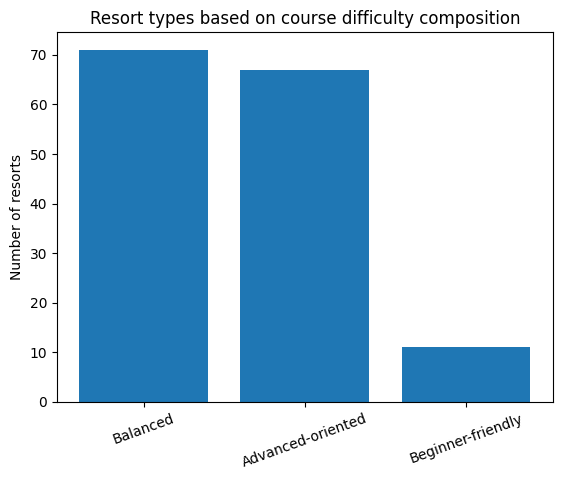

In [119]:
import matplotlib.pyplot as plt

counts = df_use["type"].value_counts()

plt.figure()
plt.bar(counts.index, counts.values)
plt.ylabel("Number of resorts")
plt.title("Resort types based on course difficulty composition")
plt.xticks(rotation=20)
plt.show()


## 分析結果のまとめ

分析の結果、Balaned型およびAdvanced-priented型のスキー場が多くを示しており、初心者向けのスキー場は少数であることが確認できた。

この結果から、初心者旅行者は事前にコース構成を確認することが湯様であると考えられる。